In [548]:
import os
import cv2
import copy
import csv
import random
import pickle
import numpy as np
import pandas as pd
import itertools
from scipy.stats import randint
from itertools import cycle
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [549]:
from sklearn import preprocessing
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from scipy.sparse import csr_matrix
from scipy import stats
from my_ml_lib import DataManipulationTools, MetricTools, PlotTools
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [550]:
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCA
from skimage.feature import hog, local_binary_pattern

In [551]:
def write_csv(file, a1, a2, a3, a4, a5, a6, a7, name):
    with open(file, mode='w') as csv_file:
        csv_writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        csv_writer.writerow(name)
        for i in range(20):
            if a2[i] == None:
                a2[i] = 'None'
            if a4[i] == None:
                a4[i] = 'None'
            csv_writer.writerow([a1[i], a2[i], a3[i], a4[i], a5[i], a6[i], a7[i]])

In [733]:
def read_images(path='content/sample_data/cell_images'):
    images = []
    labels = []
    num1 = 32
    num2 = 32
    file_name='Parasitized'
    for file_name in os.listdir(path):
        file_path = path + '/' + file_name
        for img_name in os.listdir(file_path):
            if not img_name.startswith('.'):
                if img_name.endswith('.png'):
                    img = cv2.imread(file_path + '/' + img_name)
                    new_img = cv2.resize(img, (num2, num1))
                    images.append(new_img)
                    if file_name == 'Parasitized':
                        label = 0
                    else:
                        label = 1
                    labels.append(label)
    
    return np.array(images), np.array(labels)

# New Section

In [692]:
def save_feature(feature, name):
    # saving all our feature vectors in pickled file
    with open('content/sample_data/cache/' + name + '.pkl', 'wb') as fp:
        pickle.dump(csr_matrix(feature), fp)
    
    print(f'Feature saved with name cache/{name}.pkl')

def load_feature(feature_name):
    return pickle.load(open(feature_name, 'rb')).A

In [693]:
def save_model(model):
    filename = input('Enter model file name:')
    pickle.dump(model, open('models/'+filename + '.pkl', 'wb'))
    print(f'Successfully saved model in models/{filename}.pkl')

def load_model(model_name):
    return pickle.load(open(model_name, 'rb'))

In [555]:
def get_flattened(images, color=cv2.COLOR_RGB2GRAY, name='flattened', save=False):
    """
    color: default RGB2GRAY, if None is passed then color is used as it is.
    """
    color_images = []
    if color is not None:
        for img in images:
            color_images.append(cv2.cvtColor(img, color))
    else:
        color_images = images
    
    count = len(color_images)
    
    result = np.array(color_images).reshape(count, -1)
    
    if save:
        save_feature(result, name)
        
    return result

In [556]:
def get_color_hist(images, name='color_hist', save=False):
    histograms = []
    for img in images:
        histograms.append(cv2.calcHist([img], [0, 1, 2],None, [8, 8, 8], [0, 256, 0, 256, 0, 256]).flatten())
    
    result = np.array(histograms)
    
    if save:
        save_feature(result, name)
        
    return result

In [557]:
def get_hog(images, name='hog', save=False):
    result = np.array([hog(img, block_norm='L2') for img in images])
    
    if save:
        save_feature(result, name)
        
    return result

In [559]:
def combine_features(features, horizontal=True):
    """
    Array of features [f1, f2, f3] where each fi is a feature set 
    eg. f1=rgb_flat, f2=SIFT, etc.
    """
    if horizontal:
        return np.hstack(features)
    else:
        return np.vstack(features)

In [560]:
def norm_features_minmax(train, test):
    min_max_scaler = preprocessing.MinMaxScaler()
    norm_train = min_max_scaler.fit_transform(train)
    norm_test = min_max_scaler.transform(test)
    
    return norm_train, norm_test

In [561]:
def norm_features_zscore(train, test):
    min_max_scaler = preprocessing.StandardScaler()
    norm_train = min_max_scaler.fit_transform(train)
    norm_test = min_max_scaler.transform(test)
    
    return norm_train, norm_test

In [562]:
def train_model(train_x, train_y, model_name, validation=None):
   
    model = None
    if model_name == 'SVM':
        model = svm.SVC(gamma='scale', probability=True)
    elif model_name == 'XGB':
        model = XGBClassifier(n_estimators=200, max_depth=5, n_jobs=2)
#         model = XGBClassifier()
    elif model_name == 'MLP':
        model = MLPClassifier(hidden_layer_sizes=(100,100,100), max_iter=800, alpha=0.0001,
                     solver='sgd', verbose=10, tol=0.000000001)
    elif model_name == 'ADA':
        model = AdaBoostClassifier(n_estimators=50)
    elif model_name == 'BAG':
        model = BaggingClassifier(n_jobs=2, n_estimators=50)
    elif model_name == 'RF':
        model = RandomForestClassifier(n_estimators=200, max_depth=10)
    elif model_name == 'KNN':
        model = KNeighborsClassifier(n_neighbors=5, weights='distance', algorithm='auto', leaf_size=30, p=2, metric='minkowski', metric_params=None, n_jobs=None)
    else:
        model = GaussianNB()
    
    model.fit(train_x, train_y)
    
    if validation is not None:
        y_hat = model.predict(validation[0])
        acc = metrics.accuracy_score(validation[1], y_hat)
        print(f"Validation Accuracy in '{model_name}' = {acc}")
        cm = metrics.confusion_matrix(validation[1], y_hat)
        print(cm)
        recall = cm[0][0] / (cm[0][0] + cm[0][1])
        precision = cm[0][0] / (cm[0][0] + cm[1][0])
        f1 = 2*(precision*recall)/(precision+recall)
        print(f"Recall in '{model_name}' = {recall}")
        print(f"Precision in '{model_name}' = {precision}")
        print(f"F1 Score in '{model_name}' = {f1}")
               
    return model

In [563]:
def plot_roc(fpr, tpr, class_name, area):
    figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
    
    plt.plot(fpr,tpr)

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    plt.show()

In [564]:
def plot_combine_roc(test_y, prob):
    n_classes = 6
    name_arr = ['RF', 'BAG', 'NB', 'SVM', 'KNN', 'XGB']
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = metrics.roc_curve(test_y, prob[:, i])
        roc_auc[i] = metrics.roc_auc_score(test_y,  prob[:, i])

    figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
    colors = cycle(['darkorange', 'cornflowerblue', 'red', 'purple', 'pink', 'violet', 'green'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color,
                 label='ROC curve for ' + name_arr[i] + ' class (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
#     plt.savefig('output/roc_lda_on_pca_uninfected.png')
    plt.show()

In [565]:
def confusion_mat(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues, figsize=(7,7), path=None, filename=None):
        """
        cm: confusion matrix to be plotted.
        classes: array of labels or class names.
        title: title of the confusion matrix.
        cmap: color of the plot matrix.
        figsize: tupple (width, height) representiong size of the plot.
        path: destination where the plot image will be saved.
        filename: name to save the file with on the specified path. (if None, title is used)
        
        # Source: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
        """
        cm = cm.astype(np.int64)
        plt.figure(figsize=figsize)
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)

        fmt = 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        plt.grid(False)
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.tight_layout()
        
        if path:
            if filename is None:
                plt.savefig(path + title + '.png')
            else:
                plt.savefig(path + filename + '.png')
        plt.show()


In [566]:
def pca_projection(mat, name_arr):
    plt.figure(figsize=(15,20))
    for i, img in enumerate(mat, start=1):
        plt.subplot(4, 2, i)
        y = np.var(mat[i-1], axis=0)
        x = list(range(1, len(y)+1))
        plt.plot(x, y, '--o')
        plt.ylabel('Variance')
        plt.xlabel('Data Projected on Eigen Vector Number')
        plt.xticks(x)
        plt.title(name_arr[i-1])
    plt.savefig('content/sample_data/output/pca/subplot.png')
    plt.show()

In [567]:
def draw_key_points(image, kp):
    img = cv2.drawKeypoints(image, kp, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    return img

In [568]:
full_data_x, full_data_y = read_images('content/sample_data/cell_images')

In [569]:
full_data_x.shape, full_data_y.shape

((27558, 32, 32, 3), (27558,))

In [570]:
full_data_x[2].shape

(32, 32, 3)

In [571]:
data_x, test_x, data_y, test_y = train_test_split(full_data_x, full_data_y, test_size=0.2)

In [572]:
data_x.shape, test_x.shape, data_y.shape, test_y.shape

((22046, 32, 32, 3), (5512, 32, 32, 3), (22046,), (5512,))

In [573]:
train_imgs, val_imgs, train_y, val_y = train_test_split(data_x, data_y, test_size=0.2)

In [574]:
train_imgs.shape, val_imgs.shape, train_y.shape, val_y.shape

((17636, 32, 32, 3), (4410, 32, 32, 3), (17636,), (4410,))

In [575]:
np.save('content/sample_data/data/train_imgs.npy', train_imgs)
np.save('content/sample_data/data/train_y.npy', train_y)
np.save('content/sample_data/data/val_imgs.npy', val_imgs)
np.save('content/sample_data/data/val_y.npy', val_y)

np.save('content/sample_data/data/data_x.npy', data_x)
np.save('content/sample_data/data/data_y.npy', data_y)
np.save('content/sample_data/data/test_x.npy', test_x)
np.save('content/sample_data/data/test_y.npy', test_y)

In [576]:
train_imgs = np.load('content/sample_data/data/train_imgs.npy')
train_y = np.load('content/sample_data/data/train_y.npy')
val_imgs = np.load('content/sample_data/data/val_imgs.npy')
val_y = np.load('content/sample_data/data/val_y.npy')

data_x = np.load('content/sample_data/data/data_x.npy')
data_y = np.load('content/sample_data/data/data_y.npy')
test_x = np.load('content/sample_data/data/test_x.npy')
test_y = np.load('content/sample_data/data/test_y.npy')

In [577]:
data_x.shape, test_x.shape, data_y.shape, test_y.shape


((22046, 32, 32, 3), (5512, 32, 32, 3), (22046,), (5512,))

In [578]:
train_imgs.shape, val_imgs.shape, train_y.shape, val_y.shape

((17636, 32, 32, 3), (4410, 32, 32, 3), (17636,), (4410,))

In [579]:
infected_img = train_imgs[train_y == 0][8]
uninfected_img = train_imgs[train_y == 1][4]
classes = []
classes.append(infected_img)
classes.append(uninfected_img)
class_label= []
class_label.append('infected image')
class_label.append('uninfected image')

In [580]:
vis_img = np.zeros((2, 32, 32))
for i in range(2):
    temp1, vis_img[i] = hog(classes[i], block_norm='L2', visualize=True)

In [581]:
data_vis = []
for i in range(len(classes)):
    data_vis.append(classes[i])
for i in range(len(classes)):
    data_vis.append(vis_img[i-1])


img_name_arr = []
for i in range(len(classes)):
    img_name_arr.append(class_label[i])
for i in range(len(classes)):
    img_name_arr.append('HOG')


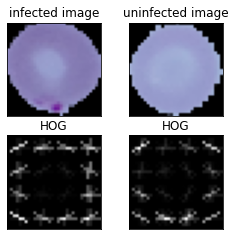

In [582]:
plt.figure(figsize=(4,10))
for i, img in enumerate(data_vis, start=1):
    plt.subplot(5, 2, i)
    plt.title(img_name_arr[i-1])
    frame1 = plt.gca()
    for tick in frame1.axes.get_xticklines():
        tick.set_visible(False)
    for tick in frame1.axes.get_yticklines():
        tick.set_visible(False)
    for xlabel_i in frame1.axes.get_xticklabels():
        xlabel_i.set_visible(False)
    for xlabel_i in frame1.axes.get_yticklabels():
        xlabel_i.set_visible(False)
    plt.imshow(data_vis[i-1], cmap='gray')
#plt.savefig('/content/sample_data/output/feature_visualization.png')
plt.show()

In [694]:
hog_train = get_hog(train_imgs, name='hog_train', save=True)
hog_val = get_hog(val_imgs, name='hog_val', save=True)

Feature saved with name cache/hog_train.pkl
Feature saved with name cache/hog_val.pkl


In [690]:
hog_train = load_feature('content/sample_data/cache/hog_train.pkl')
hog_val = load_feature('content/sample_data/cache/hog_val.pkl')

In [691]:
hog_train.shape, hog_val.shape

((17636, 324), (4410, 324))

In [586]:
flat_rgb_train = get_flattened(train_imgs, None, name='flat_rgb_train', save=True)
flat_rgb_val = get_flattened(val_imgs, None, name='flat_rgb_val', save=True)

Feature saved with name cache/flat_rgb_train.pkl
Feature saved with name cache/flat_rgb_val.pkl


In [587]:
flat_rgb_train = load_feature('content/sample_data/cache/flat_rgb_train.pkl')
flat_rgb_val = load_feature('content/sample_data/cache/flat_rgb_val.pkl')

In [588]:
flat_rgb_train.shape, flat_rgb_val.shape

((17636, 3072), (4410, 3072))

In [589]:
flat_gray_train = get_flattened(train_imgs, name='flat_gray_train', save=True)
flat_gray_val = get_flattened(val_imgs, name='flat_gray_val', save=True)

Feature saved with name cache/flat_gray_train.pkl
Feature saved with name cache/flat_gray_val.pkl


In [590]:
flat_gray_train = load_feature('content/sample_data/cache/flat_gray_train.pkl')
flat_gray_val = load_feature('content/sample_data/cache/flat_gray_val.pkl')

In [591]:
flat_gray_train.shape, flat_gray_val.shape

((17636, 1024), (4410, 1024))

In [592]:
hist_train = get_color_hist(train_imgs, name='hist_train', save=True)
hist_val = get_color_hist(val_imgs, name='hist_val', save=True)

Feature saved with name cache/hist_train.pkl
Feature saved with name cache/hist_val.pkl


In [593]:
hist_train = load_feature('content/sample_data/cache/hist_train.pkl')
hist_val = load_feature('content/sample_data/cache/hist_val.pkl')


In [594]:
hist_train.shape, hist_val.shape

((17636, 512), (4410, 512))

In [595]:
norm_hog_train, norm_hog_val = norm_features_zscore(hog_train, hog_val)

In [596]:
pca = PCA(n_components=10)
pca_hog_train = pca.fit_transform(norm_hog_train)
pca_hog_val = pca.transform(norm_hog_val)

In [597]:
np.save('content/sample_data/cache/pca_hog_train.npy', pca_hog_train)
np.save('content/sample_data/cache/pca_hog_val.npy', pca_hog_val)

In [598]:
pca_hog_train = np.load('content/sample_data/cache/pca_hog_train.npy')
pca_hog_val = np.load('content/sample_data/cache/pca_hog_val.npy')

In [599]:
pca_hog_train.shape, pca_hog_val.shape

((17636, 10), (4410, 10))

In [600]:
norm_flat_rgb_train, norm_flat_rgb_val = norm_features_zscore(flat_rgb_train, flat_rgb_val)

In [601]:
pca = PCA(n_components=10)
pca_flat_rgb_train = pca.fit_transform(norm_flat_rgb_train)
pca_flat_rgb_val = pca.transform(norm_flat_rgb_val)

In [602]:
np.save('content/sample_data/cache/pca_flat_rgb_train.npy', pca_flat_rgb_train)
np.save('content/sample_data/cache/pca_flat_rgb_val.npy', pca_flat_rgb_val)

In [603]:
pca_flat_rgb_train = np.load('content/sample_data/cache/pca_flat_rgb_train.npy')
pca_flat_rgb_val = np.load('content/sample_data/cache/pca_flat_rgb_val.npy')

In [604]:
pca_flat_rgb_train.shape, pca_flat_rgb_val.shape

((17636, 10), (4410, 10))

In [605]:
norm_flat_gray_train, norm_flat_gray_val = norm_features_zscore(flat_gray_train, flat_gray_val)

In [606]:
pca = PCA(n_components=10)
pca_flat_gray_train = pca.fit_transform(norm_flat_gray_train)
pca_flat_gray_val = pca.transform(norm_flat_gray_val)

In [607]:
np.save('content/sample_data/cache/pca_flat_gray_train.npy', pca_flat_gray_train)
np.save('content/sample_data/cache/pca_flat_gray_val.npy', pca_flat_gray_val)

In [608]:
pca_flat_gray_train = np.load('content/sample_data/cache/pca_flat_gray_train.npy')
pca_flat_gray_val = np.load('content/sample_data/cache/pca_flat_gray_val.npy')

In [609]:
pca_flat_gray_train.shape, pca_flat_gray_val.shape

((17636, 10), (4410, 10))

In [610]:
norm_hist_train, norm_hist_val = norm_features_zscore(hist_train, hist_val)

In [611]:
pca = PCA(n_components=10)
pca_hist_train = pca.fit_transform(norm_hist_train)
pca_hist_val = pca.transform(norm_hist_val)

In [612]:
np.save('content/sample_data/cache/pca_hist_train.npy', pca_hist_train)
np.save('content/sample_data/cache/pca_hist_val.npy', pca_hist_val)

In [613]:
pca_hist_train = np.load('content/sample_data/cache/pca_hist_train.npy')
pca_hist_val = np.load('content/sample_data/cache/pca_hist_val.npy')

In [614]:
pca_hist_train.shape, pca_hist_val.shape

((17636, 10), (4410, 10))

In [615]:
pca_array = []
pca_array.append(pca_hog_train)

pca_array.append(pca_hist_train)
pca_array.append(pca_flat_gray_train)
pca_array.append(pca_flat_rgb_train)


len(pca_array)

4

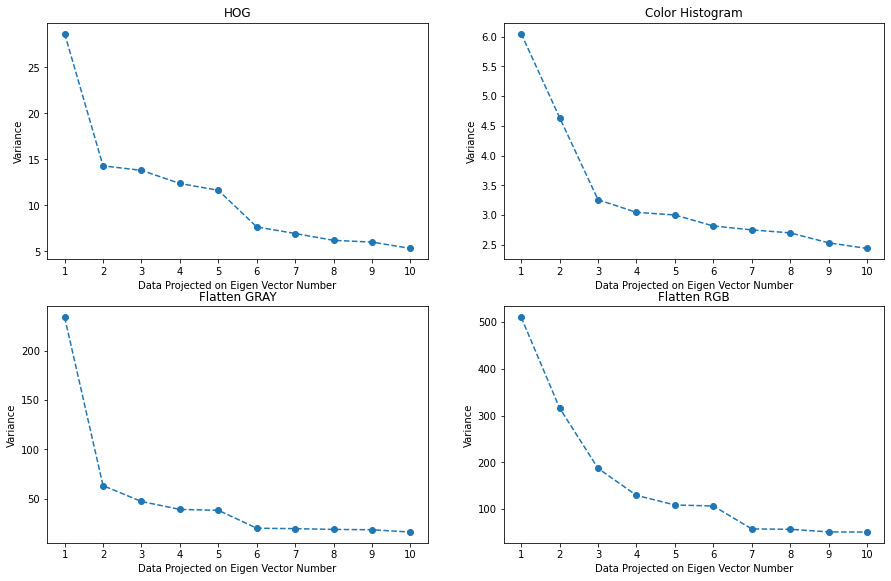

In [616]:
pca_projection(pca_array, ['HOG', 'Color Histogram', 'Flatten GRAY', 'Flatten RGB'])

In [617]:
features_train = None
features_val = None
evs = []
for ft, fv in zip([hog_train, hist_train, flat_rgb_train], 
                  [hog_val, hist_val, flat_rgb_val]):    
#     scaler = preprocessing.StandardScaler()
#     ft = scaler.fit_transform(ft)
#     fv = scaler.transform(fv)
#     ft = preprocessing.normalize(ft)
#     fv = preprocessing.normalize(fv)
    if features_train is None:
        features_train = ft
        features_val = fv
    else:
        features_train = combine_features([features_train, ft])
        features_val = combine_features([features_val, fv])

In [618]:
features_train.shape, features_val.shape
       

((17636, 3908), (4410, 3908))

In [619]:
features_train = None
features_val = None
evs = []
for ft, fv in zip([pca_hog_train, pca_flat_rgb_train, pca_hist_train,pca_flat_gray_train], 
                  [pca_hog_val, pca_flat_rgb_val, pca_hist_val,pca_flat_gray_val]):    
#     scaler = preprocessing.StandardScaler()
#     ft = scaler.fit_transform(ft)
#     fv = scaler.transform(fv)
#     ft = preprocessing.normalize(ft)
#     fv = preprocessing.normalize(fv)
    if features_train is None:
        features_train = ft
        features_val = fv
    else:
        features_train = combine_features([features_train, ft])
        features_val = combine_features([features_val, fv])

In [620]:
features_train.shape, features_val.shape

((17636, 40), (4410, 40))

In [621]:
features_t = pca_hist_train
features_v = pca_hist_val

In [622]:
features_t.shape, features_v.shape

((17636, 10), (4410, 10))

In [623]:
model1 = train_model(features_train, train_y, model_name='RF', validation=(features_val, val_y))

Validation Accuracy in 'RF' = 0.8809523809523809
[[1946  276]
 [ 249 1939]]
Recall in 'RF' = 0.8757875787578758
Precision in 'RF' = 0.8865603644646924
F1 Score in 'RF' = 0.8811410459587956


In [624]:
prob1 = model1.predict_proba(features_val)
prob10 = prob1[:,0].reshape(prob1.shape[0], 1)
prob11 = prob1[:,1].reshape(prob1.shape[0], 1)

In [625]:
model2 = train_model(features_train, train_y, model_name='BAG', validation=(features_val, val_y))

Validation Accuracy in 'BAG' = 0.8841269841269841
[[1977  245]
 [ 266 1922]]
Recall in 'BAG' = 0.8897389738973898
Precision in 'BAG' = 0.8814088274632189
F1 Score in 'BAG' = 0.8855543113101905


In [626]:
prob2 = model2.predict_proba(features_val)
prob20 = prob2[:,0].reshape(prob2.shape[0], 1)
prob21 = prob2[:,1].reshape(prob2.shape[0], 1)

In [627]:
model4 = train_model(features_train, train_y, model_name='NB', validation=(features_val, val_y))

Validation Accuracy in 'NB' = 0.6598639455782312
[[ 971 1251]
 [ 249 1939]]
Recall in 'NB' = 0.436993699369937
Precision in 'NB' = 0.7959016393442623
F1 Score in 'NB' = 0.5642068564787914


In [628]:
prob4 = model4.predict_proba(features_val)
prob40 = prob4[:,0].reshape(prob4.shape[0], 1)
prob41 = prob4[:,1].reshape(prob4.shape[0], 1)

In [629]:
model5 = train_model(features_train, train_y, model_name='SVM', validation=(features_val, val_y))

Validation Accuracy in 'SVM' = 0.8555555555555555
[[1848  374]
 [ 263 1925]]
Recall in 'SVM' = 0.8316831683168316
Precision in 'SVM' = 0.8754144954997631
F1 Score in 'SVM' = 0.852988691437803


In [630]:
prob5 = model5.predict_proba(features_val)
prob50 = prob5[:,0].reshape(prob5.shape[0], 1)
prob51 = prob5[:,1].reshape(prob5.shape[0], 1)

In [631]:
model6 = train_model(features_train, train_y, model_name='XGB', validation=(features_val, val_y))

Validation Accuracy in 'XGB' = 0.9090702947845805
[[1993  229]
 [ 172 2016]]
Recall in 'XGB' = 0.896939693969397
Precision in 'XGB' = 0.920554272517321
F1 Score in 'XGB' = 0.9085935719170276


In [632]:
prob6 = model6.predict_proba(features_val)
prob60 = prob6[:,0].reshape(prob6.shape[0], 1)
prob61 = prob6[:,1].reshape(prob6.shape[0], 1)

In [633]:
model7 = train_model(np.array(features_train), train_y, model_name='KNN', validation=(features_val, val_y))

Validation Accuracy in 'KNN' = 0.7401360544217687
[[1452  770]
 [ 376 1812]]
Recall in 'KNN' = 0.6534653465346535
Precision in 'KNN' = 0.7943107221006565
F1 Score in 'KNN' = 0.7170370370370369


In [634]:
prob7 = model7.predict_proba(features_val)
prob70 = prob7[:,0].reshape(prob7.shape[0], 1)
prob71 = prob7[:,1].reshape(prob7.shape[0], 1)

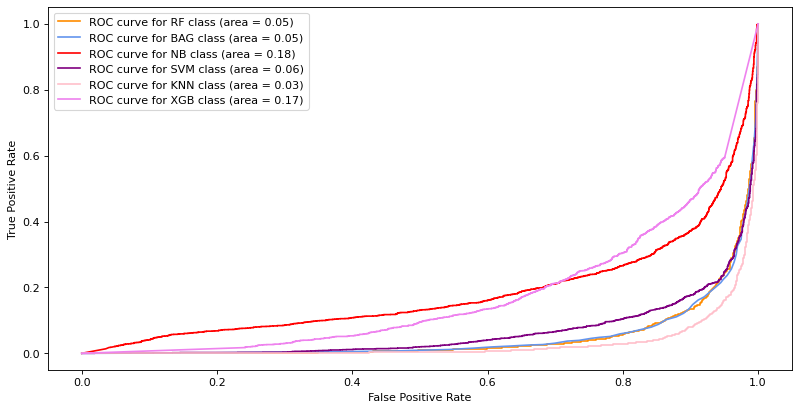

In [635]:
prob = np.concatenate((prob10,prob20, prob40, prob50, prob60 ,prob70), axis=1)
plot_combine_roc(val_y, prob)

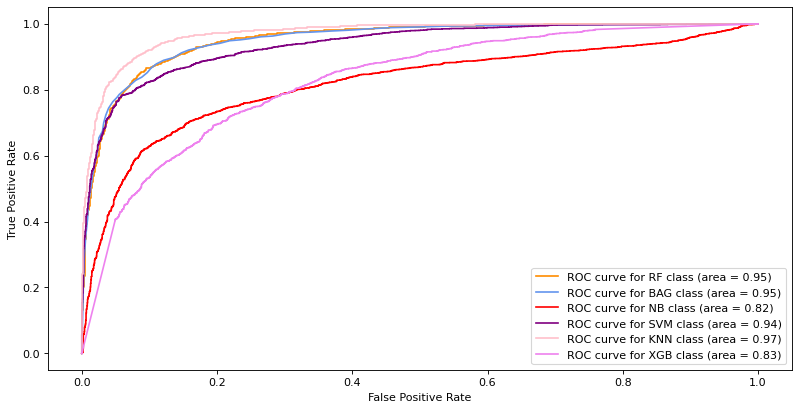

In [636]:
prob = np.concatenate((prob11,prob21, prob41, prob51,prob61, prob71), axis=1)
plot_combine_roc(val_y, prob)

In [696]:
hog_comp_train = combine_features([hog_train, hog_val], horizontal=False)
flat_rgb_comp_train = combine_features([flat_rgb_train, flat_rgb_val], horizontal=False)
flat_gray_comp_train = combine_features([flat_gray_train, flat_gray_val], horizontal=False)
hist_comp_train = combine_features([hist_train, hist_val], horizontal=False)

In [638]:
data_y = np.hstack([train_y, val_y])

In [639]:
pcas_array = []

pca = PCA(n_components=10)
pca_hog_comp_train = pca.fit_transform(hog_comp_train)
pcas_array.append(pca)

pca = PCA(n_components=20)
pca_flat_rgb_comp_train = pca.fit_transform(flat_rgb_comp_train)
pcas_array.append(pca)

pca = PCA(n_components=20)
pca_flat_gray_comp_train = pca.fit_transform(flat_gray_comp_train)
pcas_array.append(pca)

pca = PCA(n_components=10)
pca_hist_comp_train = pca.fit_transform(hist_comp_train)
pcas_array.append(pca)

In [640]:
reduced_train_features=[pca_hog_comp_train,                        
                        pca_flat_rgb_comp_train,
                        pca_flat_gray_comp_train,
                        pca_hist_comp_train]

In [641]:
hog_test = get_hog(test_x, name='hog_test', save=True)
flat_rgb_test = get_flattened(test_x, None, name='flat_rgb_test', save=True)
flat_gray_test = get_flattened(test_x, name='flat_gray_test', save=True)
hist_test = get_color_hist(test_x, name='hist_test', save=True)

Feature saved with name cache/hog_test.pkl
Feature saved with name cache/flat_rgb_test.pkl
Feature saved with name cache/flat_gray_test.pkl
Feature saved with name cache/hist_test.pkl


In [642]:
test_features= [hog_test,
                
                flat_rgb_test,
                flat_gray_test,
                hist_test]

In [643]:
features_comp_train = None
features_test = None
comp_pcas = []

for i, (f_train, f_test) in enumerate(zip(reduced_train_features, 
                                          test_features)):
    if i == 4:
        continue
    f_test = pcas_array[i].transform(f_test)
    
    if features_comp_train is None:
        features_comp_train = f_train
        features_test = f_test
    else:
        features_comp_train = combine_features([features_comp_train, f_train])
        features_test = combine_features([features_test, f_test])

In [644]:
features_comp_train.shape, features_test.shape

((22046, 60), (5512, 60))

In [645]:
comp_model = train_model(features_comp_train, data_y, model_name='XGB')

In [646]:
y_hat = comp_model.predict(features_test)

In [647]:
acc = metrics.accuracy_score(test_y, y_hat)
print(acc)
cm = metrics.confusion_matrix(test_y, y_hat)
print(cm)
precision = cm[0][0] / (cm[0][0] + cm[1][0])
recall = cm[0][0] / (cm[0][0] + cm[0][1])
f1 = 2*(recall * precision) / (recall + precision)
print(precision, recall, f1)

0.7948113207547169
[[2235  539]
 [ 592 2146]]
0.7905907322249734 0.8056957462148522 0.7980717728976968


In [648]:
comp_model = train_model(features_comp_train, data_y, model_name='KNN')

In [649]:
y_hat = comp_model.predict(features_test)

In [650]:
acc = metrics.accuracy_score(test_y, y_hat)
print(acc)
cm = metrics.confusion_matrix(test_y, y_hat)
print(cm)
precision = cm[0][0] / (cm[0][0] + cm[1][0])
recall = cm[0][0] / (cm[0][0] + cm[0][1])
f1 = 2*(recall * precision) / (recall + precision)
print(precision, recall, f1)

0.6469521044992743
[[1726 1048]
 [ 898 1840]]
0.6577743902439024 0.6222062004325883 0.6394961096702482


In [651]:
comp_model = train_model(features_comp_train, data_y, model_name='RF')

In [652]:
y_hat = comp_model.predict(features_test)

In [653]:
acc = metrics.accuracy_score(test_y, y_hat)
print(acc)
cm = metrics.confusion_matrix(test_y, y_hat)
print(cm)
precision = cm[0][0] / (cm[0][0] + cm[1][0])
recall = cm[0][0] / (cm[0][0] + cm[0][1])
f1 = 2*(recall * precision) / (recall + precision)
print(precision, recall, f1)

0.7567126269956459
[[2142  632]
 [ 709 2029]]
0.7513153279551035 0.772170151405912 0.7616


In [654]:
comp_model = train_model(features_comp_train, data_y, model_name='BAG')

In [655]:
y_hat = comp_model.predict(features_test)

In [656]:
acc = metrics.accuracy_score(test_y, y_hat)
print(acc)
cm = metrics.confusion_matrix(test_y, y_hat)
print(cm)
precision = cm[0][0] / (cm[0][0] + cm[1][0])
recall = cm[0][0] / (cm[0][0] + cm[0][1])
f1 = 2*(recall * precision) / (recall + precision)
print(precision, recall, f1)

0.7748548621190131
[[2207  567]
 [ 674 2064]]
0.7660534536619229 0.7956020187454939 0.7805481874447391


In [657]:
comp_model = train_model(features_comp_train, data_y, model_name='SVM')

In [658]:
y_hat = comp_model.predict(features_test)

In [659]:
acc = metrics.accuracy_score(test_y, y_hat)
print(acc)
cm = metrics.confusion_matrix(test_y, y_hat)
print(cm)
precision = cm[0][0] / (cm[0][0] + cm[1][0])
recall = cm[0][0] / (cm[0][0] + cm[0][1])
f1 = 2*(recall * precision) / (recall + precision)
print(precision, recall, f1)

0.7213352685050798
[[2013  761]
 [ 775 1963]]
0.7220229555236729 0.7256669069935112 0.7238403451995685


In [660]:
comp_model = train_model(features_comp_train, data_y, model_name='NB')

In [661]:
y_hat = comp_model.predict(features_test)

In [662]:
acc = metrics.accuracy_score(test_y, y_hat)
print(acc)
cm = metrics.confusion_matrix(test_y, y_hat)
print(cm)
precision = cm[0][0] / (cm[0][0] + cm[1][0])
recall = cm[0][0] / (cm[0][0] + cm[0][1])
f1 = 2*(recall * precision) / (recall + precision)
print(precision, recall, f1)

0.6716255442670537
[[1884  890]
 [ 920 1818]]
0.6718972895863052 0.6791636625811103 0.67551093581929


In [735]:
clf = RandomForestClassifier(n_estimators=200)

param_dist = {"max_depth": [3, None],
              "class_weight" : ["balanced", "balanced_subsample", None],
              "min_samples_split": randint(2, 11),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

random_search = RandomizedSearchCV(clf, param_distributions=param_dist, n_iter=20, cv=5)

In [664]:
random_search.fit(features_train, train_y)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [665]:
print(random_search.cv_results_.keys())

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_bootstrap', 'param_class_weight', 'param_criterion', 'param_max_depth', 'param_min_samples_split', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])


In [666]:
a1 = random_search.cv_results_['param_bootstrap']
a2 = random_search.cv_results_['param_class_weight']
a3 = random_search.cv_results_['param_criterion']
a4 = random_search.cv_results_['param_max_depth']
a5 = random_search.cv_results_['param_min_samples_split']
a6 = random_search.cv_results_['std_test_score']

a7 = random_search.cv_results_['mean_test_score']

In [667]:
print(random_search.best_params_)

{'bootstrap': False, 'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': None, 'min_samples_split': 2}


In [668]:
arr = []
for key in random_search.best_params_.keys():
    arr.append(key)
    
arr.append('mean_train_score')
arr.append('mean_test_score')
print(arr)

['bootstrap', 'class_weight', 'criterion', 'max_depth', 'min_samples_split', 'mean_train_score', 'mean_test_score']


In [669]:
y1 = random_search.predict(features_val)
metrics.accuracy_score(y1, val_y)

0.8950113378684807

In [673]:
y_hat1 = model1.predict(features_val)
y_hat2 = model2.predict(features_val)

y_hat4 = model4.predict(features_val)
y_hat5 = model5.predict(features_val)
y_hat6 = model6.predict(features_val)
y_hat7 = model7.predict(features_val)

In [676]:
cm1 = MetricTools.confusion_matrix(val_y, y_hat1, 2)
cm2 = MetricTools.confusion_matrix(val_y, y_hat2, 2)

cm4 = MetricTools.confusion_matrix(val_y, y_hat4, 2)
cm5 = MetricTools.confusion_matrix(val_y, y_hat5, 2)
cm6 = MetricTools.confusion_matrix(val_y, y_hat6, 2)
cm7 = MetricTools.confusion_matrix(val_y, y_hat7, 2)

In [677]:
print(cm1)
print(cm2)

print(cm4)
print(cm5)
print(cm6)
print(cm7)

[[1946.  276.]
 [ 249. 1939.]]
[[1977.  245.]
 [ 266. 1922.]]
[[ 971. 1251.]
 [ 249. 1939.]]
[[1848.  374.]
 [ 263. 1925.]]
[[1993.  229.]
 [ 172. 2016.]]
[[1452.  770.]
 [ 376. 1812.]]


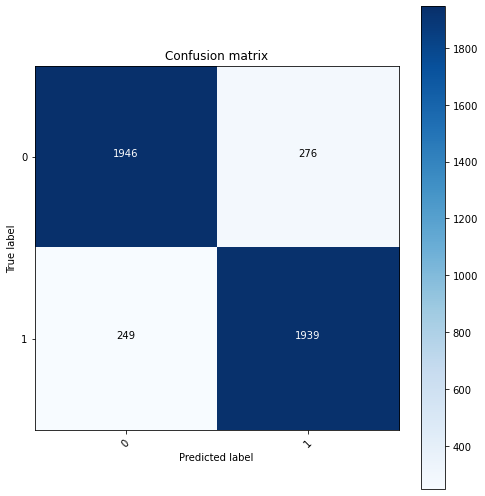

In [678]:
PlotTools.confusion_matrix(cm1, list(range(2)))

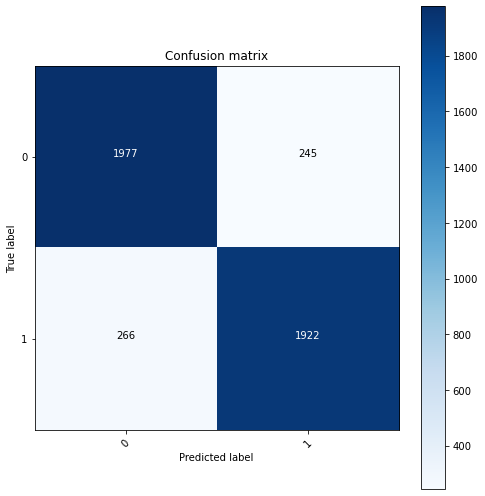

In [679]:
PlotTools.confusion_matrix(cm2, list(range(2)))

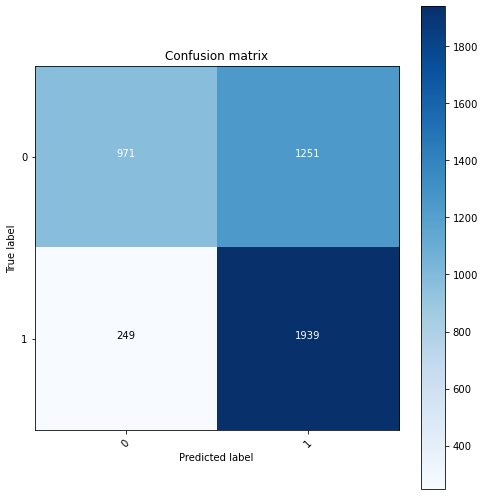

In [680]:
PlotTools.confusion_matrix(cm4, list(range(2)))

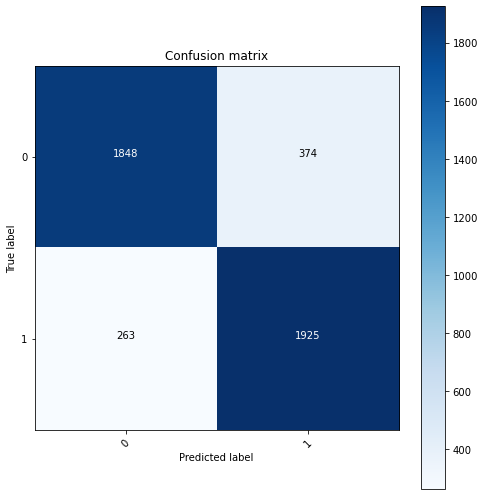

In [681]:
PlotTools.confusion_matrix(cm5, list(range(2)))

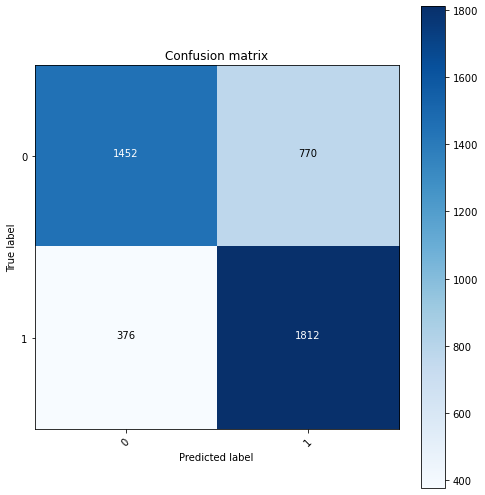

In [682]:
PlotTools.confusion_matrix(cm7, list(range(2)))

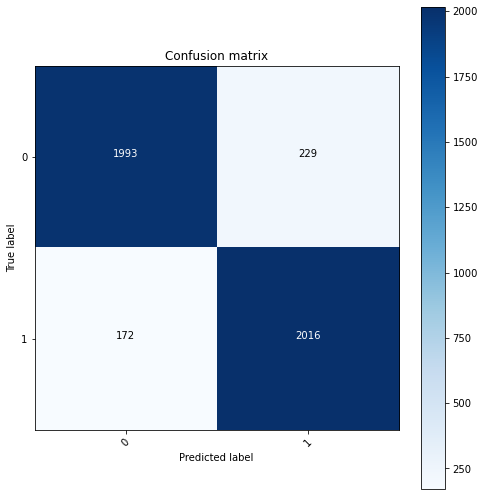

In [697]:
PlotTools.confusion_matrix(cm6, list(range(2))) #xgb  

In [701]:
features_train1 = None
features_val1 = None
evs = []
for ft, fv in zip([pca_hist_train, pca_hog_train], 
                  [pca_hist_val, pca_hog_val]):    
#     scaler = preprocessing.StandardScaler()
#     ft = scaler.fit_transform(ft)
#     fv = scaler.transform(fv)
#     ft = preprocessing.normalize(ft)
#     fv = preprocessing.normalize(fv)
    if features_train1 is None:
        features_train1 = ft
        features_val1 = fv
    else:
        features_train1 = combine_features([features_train1, ft])
        features_val1 = combine_features([features_val1, fv])
features_train1.shape, features_val1.shape

((17636, 20), (4410, 20))

In [703]:
features_train2 = None
features_val2 = None
evs = []
for ft, fv in zip([pca_hist_train, pca_flat_gray_train, pca_flat_rgb_train], 
                  [pca_hist_val, pca_flat_gray_val, pca_flat_rgb_val]):    
#     scaler = preprocessing.StandardScaler()
#     ft = scaler.fit_transform(ft)
#     fv = scaler.transform(fv)
#     ft = preprocessing.normalize(ft)
#     fv = preprocessing.normalize(fv)
    if features_train2 is None:
        features_train2 = ft
        features_val2 = fv
    else:
        features_train2 = combine_features([features_train2, ft])
        features_val2 = combine_features([features_val2, fv])
features_train2.shape, features_val2.shape

((17636, 30), (4410, 30))

In [702]:

model1 = train_model(features_train1, train_y, model_name='SVM', validation=(features_val1, val_y))
prob1 = model1.predict_proba(features_val1)

Validation Accuracy in 'SVM' = 0.8802721088435375
[[1927  295]
 [ 233 1955]]
Recall in 'SVM' = 0.8672367236723673
Precision in 'SVM' = 0.8921296296296296
F1 Score in 'SVM' = 0.8795070743952532


In [704]:
model2 = train_model(features_train2, train_y, model_name='SVM', validation=(features_val2, val_y))
prob2 = model2.predict_proba(features_val2)

Validation Accuracy in 'SVM' = 0.7875283446712018
[[1689  533]
 [ 404 1784]]
Recall in 'SVM' = 0.7601260126012601
Precision in 'SVM' = 0.8069756330625896
F1 Score in 'SVM' = 0.7828505214368482


In [705]:
prob1 = model1.predict_proba(features_val1)
prob2 = model2.predict_proba(features_val2)


In [706]:
prob = (prob1 + prob2 ) / 2
y_hat = np.argmax(prob, axis=1)

In [707]:
metrics.accuracy_score(val_y, y_hat)

0.8768707482993198

In [708]:
model1 = train_model(features_train1, train_y, model_name='KNN', validation=(features_val1, val_y))
prob1 = model1.predict_proba(features_val1)

Validation Accuracy in 'KNN' = 0.8412698412698413
[[1809  413]
 [ 287 1901]]
Recall in 'KNN' = 0.8141314131413141
Precision in 'KNN' = 0.8630725190839694
F1 Score in 'KNN' = 0.8378879110699397


In [709]:
model2 = train_model(features_train2, train_y, model_name='KNN', validation=(features_val2, val_y))
prob2 = model2.predict_proba(features_val2)

Validation Accuracy in 'KNN' = 0.6727891156462585
[[1425  797]
 [ 646 1542]]
Recall in 'KNN' = 0.6413141314131413
Precision in 'KNN' = 0.6880733944954128
F1 Score in 'KNN' = 0.6638714185883997


In [710]:
prob1 = model1.predict_proba(features_val1)
prob2 = model2.predict_proba(features_val2)


In [711]:
prob = (prob1 + prob2 ) / 2
y_hat = np.argmax(prob, axis=1)

In [712]:
metrics.accuracy_score(val_y, y_hat)

0.8204081632653061

In [713]:
model1 = train_model(features_train1, train_y, model_name='RF', validation=(features_val1, val_y))
prob1 = model1.predict_proba(features_val1)

Validation Accuracy in 'RF' = 0.8802721088435375
[[1954  268]
 [ 260 1928]]
Recall in 'RF' = 0.8793879387938794
Precision in 'RF' = 0.8825654923215899
F1 Score in 'RF' = 0.8809738503155997


In [714]:
model2 = train_model(features_train2, train_y, model_name='RF', validation=(features_val2, val_y))
prob2 = model2.predict_proba(features_val2)

Validation Accuracy in 'RF' = 0.8519274376417234
[[1806  416]
 [ 237 1951]]
Recall in 'RF' = 0.8127812781278128
Precision in 'RF' = 0.8839941262848752
F1 Score in 'RF' = 0.8468933177022273


In [715]:
prob1 = model1.predict_proba(features_val1)
prob2 = model2.predict_proba(features_val2)

In [716]:
prob = (prob1 + prob2 ) / 2
y_hat = np.argmax(prob, axis=1)

In [717]:
metrics.accuracy_score(val_y, y_hat)

0.881859410430839

In [718]:
model1 = train_model(features_train1, train_y, model_name='NB', validation=(features_val1, val_y))
prob1 = model1.predict_proba(features_val1)

Validation Accuracy in 'NB' = 0.654421768707483
[[ 912 1310]
 [ 214 1974]]
Recall in 'NB' = 0.41044104410441046
Precision in 'NB' = 0.8099467140319716
F1 Score in 'NB' = 0.5448028673835126


In [719]:
model2 = train_model(features_train2, train_y, model_name='NB', validation=(features_val2, val_y))
prob2 = model2.predict_proba(features_val2)

Validation Accuracy in 'NB' = 0.5678004535147392
[[ 502 1720]
 [ 186 2002]]
Recall in 'NB' = 0.22592259225922592
Precision in 'NB' = 0.7296511627906976
F1 Score in 'NB' = 0.3450171821305842


In [720]:
prob1 = model1.predict_proba(features_val1)
prob2 = model2.predict_proba(features_val2)

In [721]:
prob = (prob1 + prob2 ) / 2
y_hat = np.argmax(prob, axis=1)

In [722]:
metrics.accuracy_score(val_y, y_hat)

0.6219954648526077

In [723]:
model1 = train_model(features_train1, train_y, model_name='BAG', validation=(features_val1, val_y))
prob1 = model1.predict_proba(features_val1)

Validation Accuracy in 'BAG' = 0.8834467120181406
[[1974  248]
 [ 266 1922]]
Recall in 'BAG' = 0.8883888388838884
Precision in 'BAG' = 0.88125
F1 Score in 'BAG' = 0.8848050201703272


In [724]:
model2 = train_model(features_train2, train_y, model_name='BAG', validation=(features_val2, val_y))
prob2 = model2.predict_proba(features_val2)

Validation Accuracy in 'BAG' = 0.8680272108843538
[[1874  348]
 [ 234 1954]]
Recall in 'BAG' = 0.8433843384338434
Precision in 'BAG' = 0.8889943074003795
F1 Score in 'BAG' = 0.8655889145496536


In [725]:
prob1 = model1.predict_proba(features_val1)
prob2 = model2.predict_proba(features_val2)

In [726]:
prob = (prob1 + prob2 ) / 2
y_hat = np.argmax(prob, axis=1)

In [727]:
metrics.accuracy_score(val_y, y_hat)

0.8947845804988662

In [728]:
model1 = train_model(features_train1, train_y, model_name='XGB', validation=(features_val1, val_y))
prob1 = model1.predict_proba(features_val1)

Validation Accuracy in 'XGB' = 0.9002267573696145
[[1985  237]
 [ 203 1985]]
Recall in 'XGB' = 0.8933393339333934
Precision in 'XGB' = 0.9072212065813529
F1 Score in 'XGB' = 0.9002267573696145


In [741]:
model2 = train_model(features_train2, train_y, model_name='XGB', validation=(features_val2, val_y))
prob2 = model2.predict_proba(features_val2)

Validation Accuracy in 'XGB' = 0.8886621315192744
[[1915  307]
 [ 184 2004]]
Recall in 'XGB' = 0.8618361836183618
Precision in 'XGB' = 0.912339209147213
F1 Score in 'XGB' = 0.8863688960888684


In [738]:
prob1 = model1.predict_proba(features_val1)
prob2 = model2.predict_proba(features_val2)

In [739]:
prob = (prob1 + prob2 ) / 2
y_hat = np.argmax(prob, axis=1)

In [740]:
metrics.accuracy_score(val_y, y_hat)

0.9079365079365079